# <center> Практика. Статистические тесты в контексте EDA

## Постановка задачи

Необходимо исследовать данные HR-агентства, изучающего тренды на рынке труда в IT, и сделать выводы по полученным результатам. В данных содержится информация о зарплатах в сфере Data Science за 2020–2022 г.

В процессе анализа нужно будет:

* Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
* Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
* Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
* Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
* Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


Данные содержатся в следующих столбцах:
* **work_year** - год, в котором была выплачена зарплата.
* **experience_level** - опыт работы на этой должности в течение года со следующими возможными значениями:
   * EN — Entry-level/Junior;
   * MI — Mid-level/Intermediate;
   * SE — Senior-level/Expert;
   * EX — Executive-level/Director.
* **employment_type** - тип трудоустройства для этой роли:
   * PT — неполный рабочий день;
   * FT — полный рабочий день;
   * CT — контракт;
   * FL — фриланс.
* **job_title** - роль, в которой соискатель работал в течение года.
* **salary** - общая выплаченная валовая сумма заработной платы.
* **salary_currency** - валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.
* **salary_in_usd** - зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).
* **employee_residence** -основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.
* **remote_ratio** - общий объём работы, выполняемой удалённо. Возможные значения:
   * 0 — удалённой работы нет (менее 20 %);
   * 50 — частично удалённая работа;
   * 100 — полностью удалённая работа (более 80 %).
* **company_location** - страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.
* **company_size** - среднее количество людей, работавших в компании в течение года:
   * S — менее 50 сотрудников (небольшая компания);
   * M — от 50 до 250 сотрудников (средняя компания);
   * L — более 250 сотрудников (крупная компания).

## Загрузка данных

In [42]:
# Загрузка библиотек, необходимых для анализа

import zipfile
import requests

import pandas as pd
import numpy as np

import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from ydata_profiling import ProfileReport
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

# Визуальная настройка графиков
sns.set_theme("notebook")
sns.set_palette("tab20b")

In [43]:
# Имя, для сохранения файла
file_name = 'ds_salaries.zip'

# Форматирование URL для загрузки
download_url = "https://lms.skillfactory.ru/asset-v1:SkillFactory+DST-3.0+28FEB2021+type@asset+block@ds_salaries.zip"

# Загрузка файла
r = requests.get(download_url)

# Сохранение файла в виде ZIP
with open(file_name, 'wb') as f:
    f.write(r.content)

# Извлечение файла из ZIP и чтение CSV
with zipfile.ZipFile(file_name, 'r') as z:
    z.printdir()
    with z.open('ds_salaries.csv') as f:
        df = pd.read_csv(f, index_col=0)

File Name                                             Modified             Size
ds_salaries.csv                                2023-05-12 17:18:40        36960


In [44]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [45]:
# Установка уровня значимости
alpha = 0.05
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Знакомство с данными

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


В датасете 607 записей (без пропущенных значений)


In [47]:
# Генерация отчета
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# Просмотр отчета в Jupyter Notebook
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

**В ходе предварительного знакомства с данными можно сделать следующие выводы:**

1. В датасете содержится 607 записей, и отсутствуют пропуски в данных.
2. Имеется 2 числовых признака, 8 категориальных и 1 текстовый.
3. Данные охватывают период с 2020 по 2022 год, и наблюдается рост востребованности специалистов в области Data Science на рынке труда с каждым годом.
4. В основном представлены сотрудники с уровнем опыта 'middle' и 'senior'.
5. В признаке `employment_type` доминирует только один тип трудоустройства — полный рабочий день. Таким образом, данный признак окажется неинформативным для определения зависимости уровня заработной платы от типа трудоустройства. Преобладание этого типа занятости свидетельствует о необходимости полного погружения в работу, что предполагает, что область Data Science требует специалистов, готовых уделять работе достаточное количество времени. Эта сфера не подойдёт соискателям, ищущим подработку, требующую всего несколько часов в день.
6. Признак `job_title` неудобен для анализа, так как содержит слишком много уникальных значений (50), и многие роли можно сгруппировать в одну категорию.
7. В данных представлены 3 столбца с информацией о заработной плате. Для проведения дальнейшего исследования следует оставить только один признак, который будет отражать единую валюту оплаты труда.
8. В данных есть два схожих признака: `employee_residence` и `company_location`. На первый взгляд, они содержат аналогичную информацию.
9. Специалисты в области Data Science чаще всего требуются в средних и крупных компаниях.

**Для дальнейшей работы необходимо:**

1. Проверить датасет на наличие дубликатов и удалить их.
2. Провести корреляционный анализ между признаками `employee_residence` и `company_location`, чтобы на основании анализа принять решение о информативности этих столбцов.
3. Удалить неинформативные столбцы.
4. Перевести признак `job_title` из текстового формата в категориальный, выделив из текстового описания, область его работы.

**Предположения о признаках, которые могут влиять на уровень заработной платы:**

На первый взгляд, наблюдается корреляция между заработной платой и тремя признаками: `job_title`, `experience_level` и `work_year`. В ходе дальнейшего исследования необходимо будет проверить, действительно ли это так, и провести более глубокий анализ.

## Предобработка данных

1. Поиск и удаление дубликатов.

In [48]:
print(f'В датасете найдено {df[df.duplicated()].shape[0]} дубликата')

# Удаляем дубликаты:
df = df.drop_duplicates()
print(f'Размер таблицы после удаления дубликатов: {df.shape}')

В датасете найдено 42 дубликата
Размер таблицы после удаления дубликатов: (565, 11)


2. Отбор столбцов для анализа

Чтобы проводить анализ зарплаты, необходимо, чтобы в данных зарплата была указана в единой валюте. В наших данных уже есть такой столбец - "salary_in_usd". Поэтому для анализа нам не потребуются стобцы - 'salary', 'salary_currency'.

In [49]:
df = df.drop(["salary", "salary_currency"], axis=1)

У нас есть два схожих столбца:

* информация о стране проживания соискателя (employee_residence)
* информация о стране, где расположена компания (company_location).

Для того чтобы определить, можем ли мы удалить один из этих столбцов, проверим корреляцию между ними. Если корреляция окажется высокой, это позволит нам сделать вывод о том, что один из этих признаков можно будет исключить из анализа.

In [50]:
# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

# создаем объект OrdinalEncoder, col - имя столбца, mapping - словарь с описанием кодировки
ord_encoder = ce.OrdinalEncoder(mapping=[{
	'col': 'employee_residence',
	'mapping': dict(zip(df['employee_residence'].unique().tolist(), range(1, 60)))
}, {'col': 'company_location',
	'mapping': dict(zip(df['employee_residence'].unique().tolist(), range(1, 60)))}
                                         ])
# применяем трансформацию к столбцам
data_bin = ord_encoder.fit_transform(df[['employee_residence', 'company_location']])

# посчитаем корреляцию
data_bin.corr(method = 'spearman').round(2)

,employee_residence,company_location
employee_residence,1.00,0.81
company_location,0.81,1.00


Уровень корреляции больше 0.8, это говорит об очень высоком уровне корреляции. Поэтому для дальнейшего анализа оставим только один из столбцов.

In [51]:
df = df.drop(["employee_residence"], axis=1)

В данных имеется столбец 'job_title' с описанием роли, в которой соискатель работал. Посмотрим на его уникальные значения:

In [52]:
df["job_title"].unique()

array(['Data Scientist', 'Machine Learning Scientist',
       'Big Data Engineer', 'Product Data Analyst',
       'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist',
       'Business Data Analyst', 'Lead Data Engineer', 'Lead Data Analyst',
       'Data Engineer', 'Data Science Consultant', 'BI Data Analyst',
       'Director of Data Science', 'Research Scientist',
       'Machine Learning Manager', 'Data Engineering Manager',
       'Machine Learning Infrastructure Engineer', 'ML Engineer',
       'AI Scientist', 'Computer Vision Engineer',
       'Principal Data Scientist', 'Data Science Manager', 'Head of Data',
       '3D Computer Vision Researcher', 'Data Analytics Engineer',
       'Applied Data Scientist', 'Marketing Data Analyst',
       'Cloud Data Engineer', 'Financial Data Analyst',
       'Computer Vision Software Engineer',
       'Director of Data Engineering', 'Data Science Engineer',
       'Principal Data Engineer', 'Machine Learning Developer',
       

Изучив описанные роли становится понятным, что в таком виде столбец для анализа нам не подойдет. Можно сократить количество уникальных значений, распределив по 6 категориям.
Выделим следующие категории:
* Data Scientist
* Data Engineer
* Data Analyst
* Computer Vision
* Head of Data


In [53]:
print(f"До распределения - {df['job_title'].unique().shape[0]} уникальных значений в столбце")

def classify_job_title(job):
    # Проверка на наличие терминов, связанных с Data Science или Data Scientist
    if re.findall(r'\b[Dd]ata\b.*?\b[Ss]cience\b|\b[Dd]ata\b.*?\b[Ss]cientist\b|\b[Rr]esearch\b.*?\b[Ss]cientist\b', job):
        return "Data Scientist"  # Если найдено, возвращаем "Data Scientist"

    # Проверка на наличие терминов, связанных с Data Engineering
    if re.findall(r'\b[Dd]ata\b.*?\b[Ee]ngineer\b|\b[Dd]ata\b.*?\b[Ee]ngineering\b|\b[Bb]ig\b.*?\b[Dd]ata\b|\bETL\b', job) \
        or re.findall(r'\b[Dd]ata\b.*?\b[Ss]pecialist\b|\b[Dd]ata\b.*?\b[Aa]rchitect', job):
        return "Data Engineer"  # Если найдено, возвращаем "Data Engineer"

    # Проверка на наличие терминов, связанных с аналитикой
    elif re.findall(r'\b[Aa]nalyst\b|\b[Aa]nalytics\b', job):
        return "Data Analyst"  # Если найдено, возвращаем "Data Analyst"

    # Проверка на наличие терминов, связанных с машинным обучением
    elif re.findall(r'\b[Mm]achine\b.*?\b[Ll]earning\b|\bML\b|\bNLP\b|\bAI\b', job):
        return "Machine Learning"  # Если найдено, возвращаем "Machine Learning"

    # Проверка на наличие терминов, связанных с компьютерным зрением
    elif re.findall(r'\b[Cc]omputer\b.*?\b[Vv]ision\b', job):
        return "Computer Vision"  # Если найдено, возвращаем "Computer Vision"
    # Если ничего не найдено, возвращаем исходное название работы
    else:
        return job

# Применяем функцию к столбцу "job_title" в DataFrame df и перезаписываем результат
df['job_title'] = df['job_title'].apply(classify_job_title)

# Проверяем результат
df.head()

До распределения - 50 уникальных значений в столбце


,work_year,experience_level,employment_type,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,0,DE,L
1,2020,SE,FT,Machine Learning,260000,0,JP,S
2,2020,SE,FT,Data Engineer,109024,50,GB,M
3,2020,MI,FT,Data Analyst,20000,0,HN,S
4,2020,SE,FT,Machine Learning,150000,50,US,L


## Визуальный анализ данных

### Распределение уровня зарплат

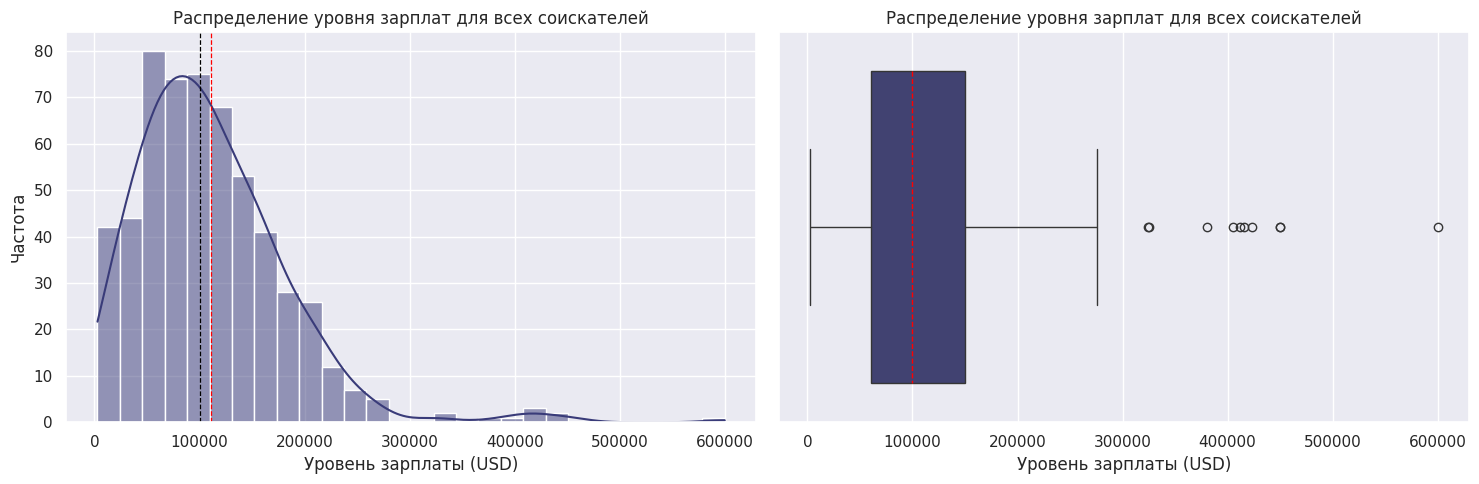

Показатель ассиметрии равен: 1.73


In [54]:
# Создание подграфиков
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Гистограмма с KDE для уровня зарплаты
sns.histplot(df['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set_xlabel('Уровень зарплаты (USD)')
axes[0].set_ylabel('Частота')
axes[0].set_title('Распределение уровня зарплат для всех соискателей')
axes[0].axvline(df['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.9)
axes[0].axvline(df['salary_in_usd'].median(), color='black', linestyle='--', linewidth=0.9)

# Ящик с усами (boxplot) для уровня зарплаты
sns.boxplot(df['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set_xlabel('Уровень зарплаты (USD)')
axes[1].set_title('Распределение уровня зарплат для всех соискателей')

# Отображение графиков
plt.tight_layout()  # Автоматическая настройка отступов
plt.show()

print(f'Показатель ассиметрии равен: {df["salary_in_usd"].skew().round(2)}')

In [55]:
describe_df = df['salary_in_usd'].describe().round().to_frame()
describe_df.columns = ['Размер зарплат']
display(describe_df)

,Размер зарплат
count,565.0
mean,110610.0
std,72281.0
min,2859.0
25%,60757.0
50%,100000.0
75%,150000.0
max,600000.0


Гистограмма распределения имеет правостороннее смещение(показатель ассиметрии больше 0). Среднее значение больше медианы, так как высокие значения на правом хвосте распределения сильно завышают значение среднего. Это типично для распределений зарплат, которые ограничены положительными значениями (поскольку зарплата не может быть отрицательной) и не имеют верхнего ограничителя.

Распределение зарплат не является нормальным.

Очистим данные от выбросов:

In [56]:
def outliers_iqr(data, feature):
    x = data[feature]

    # Вычисляем первый и третий квартиль
    quartile_1 = x.quantile(0.25)
    quartile_3 = x.quantile(0.75)

    # Рассчитываем интерквартильный размах (IQR)
    iqr = quartile_3 - quartile_1

    # Определяем границы для выбросов
    lower_bound = quartile_1 - (iqr * 2)
    upper_bound = quartile_3 + (iqr * 2)

    # Находим выбросы: значения, которые меньше нижней границы или больше верхней границы
    outliers = data[(x < lower_bound) | (x > upper_bound)]

    # Формируем очищенный DataFrame, исключая выбросы
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]

    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'salary_in_usd')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 8
Результирующее число записей: 557


In [57]:
cleaned['salary_in_usd'].describe().round().to_frame()

,salary_in_usd
count,557.0
mean,105851.0
std,60323.0
min,2859.0
25%,60000.0
50%,100000.0
75%,147000.0
max,325000.0


Средняя зарплата составляет 105851 USD.

Стандартное отклонение равно 60323 USD, что указывает на значительное разнообразие в зарплатах. Высокое стандартное отклонение относительно среднего говорит о том, что зарплаты сильно варьируются.

Минимальная зарплата составляет 2859 USD, максимальная зарплата после очистки от выбросов -  325000 USD.



### Распредение зарплаты в зависимости от опыта работа.

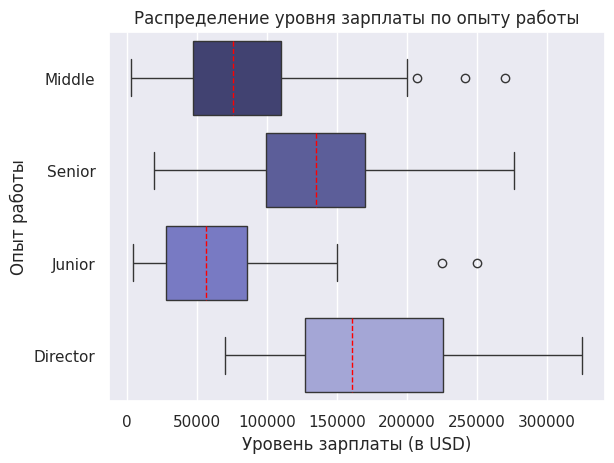

In [58]:
# Создаем boxplot, применяя разные цвета для каждого уровня опыта
ax = sns.boxplot(
    data=cleaned,
    x='salary_in_usd',
    y='experience_level',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    hue='experience_level'
)

# Настраиваем подписи осей
ax.set(xlabel='Уровень зарплаты (в USD)', ylabel='Опыт работы')

# Установка пользовательских меток для уровней опыта
ax.set_yticks(range(4))
ax.set_yticklabels(['Middle', 'Senior', 'Junior', 'Director'])

# Установка заголовка графика
plt.title('Распределение уровня зарплаты по опыту работы')

# Отображаем график
plt.show()

In [59]:
df_agg = cleaned.groupby('experience_level')['salary_in_usd'].describe().round()
print('Распределение уровня зарплаты по опыту работы')
df_agg

Распределение уровня зарплаты по опыту работы


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.0,44396.0,4000.0,27505.0,56500.0,85426.0,250000.0
EX,24.0,173675.0,72040.0,69741.0,127047.0,160771.0,225500.0,325000.0
MI,205.0,82624.0,48040.0,2859.0,46809.0,75774.0,110000.0,270000.0
SE,240.0,135117.0,52671.0,18907.0,99282.0,135000.0,170000.0,276000.0


Уровень зарплаты различен для разного опыта работа. Чем больше опыт работы, тем более высокую оплату труд получает соискатель.
Среди 'junior' и 'middle' наблюдается небольшое количество выбросов. Маловероятно, что только начинающий карьеру в области Data Science сотрудник сможет получать зарплату на уровне с экспертами в этой области.

Чтобы определить являются ли эти различия статистически значимыми, в следующем разделе будеут проведены статистические тесты.

## Распределение уровня зарплат в зависимости от типа трудоустройства

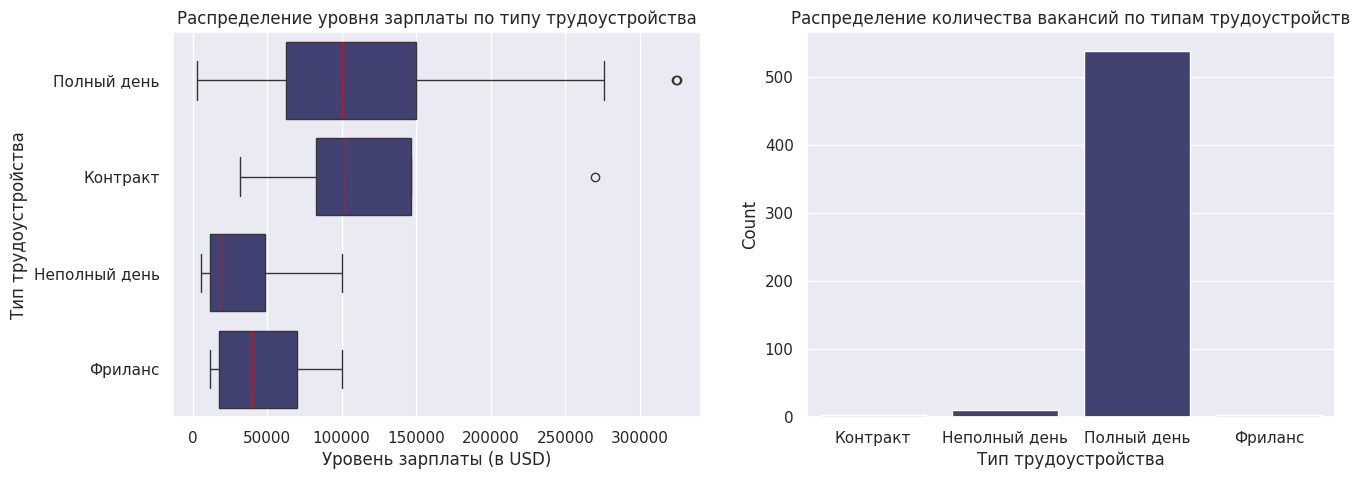

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

dict_replacement = {'FT': 'Полный день',
                    'CT': 'Контракт',
                    'PT': 'Неполный день',
                    'FL': 'Фриланс'}
data_t = cleaned.copy()
data_t['employment_type'] = data_t['employment_type'].map(dict_replacement)

# Создаем boxplot, применяя разные цвета для каждого уровня опыта
sns.boxplot(
    data=data_t,
    x='salary_in_usd',
    y='employment_type',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    ax=axes[0]
)

# Настраиваем подписи осей
axes[0].set(xlabel='Уровень зарплаты (в USD)', ylabel='Тип трудоустройства')

# Установка заголовка графика
axes[0].set_title('Распределение уровня зарплаты по типу трудоустройства')

# Считаем количество работ по каждому типу трудоустройства
df_type = data_t.groupby('employment_type').size().reset_index(name='count')

# Создаем barplot
axes[1] = sns.barplot(
    data=df_type,
    x='employment_type',
    y='count'
)

# Настраиваем подписи осей
axes[1].set(xlabel='Тип трудоустройства', ylabel='Count')

# Установка заголовка второго графика
axes[1].set_title('Распределение количества вакансий по типам трудоустройств')

# Отображаем график
plt.show();

Уровень зарплаты зависит от типа трудоустройства. При полной занятости у работников зарплата выше. Но если взглянуть на количество ваканский в разрезетипа трудоустройства, то увидим, что практически все вакансии в датасете затрагивают именно "полный рабочий день". Поэтому для анализа этот признак не так важен, так как в данных сконцентрирован один тип трудоустройства.

## Распреление уровня зарплаты в зависимости от области, в которой работает сотрудник

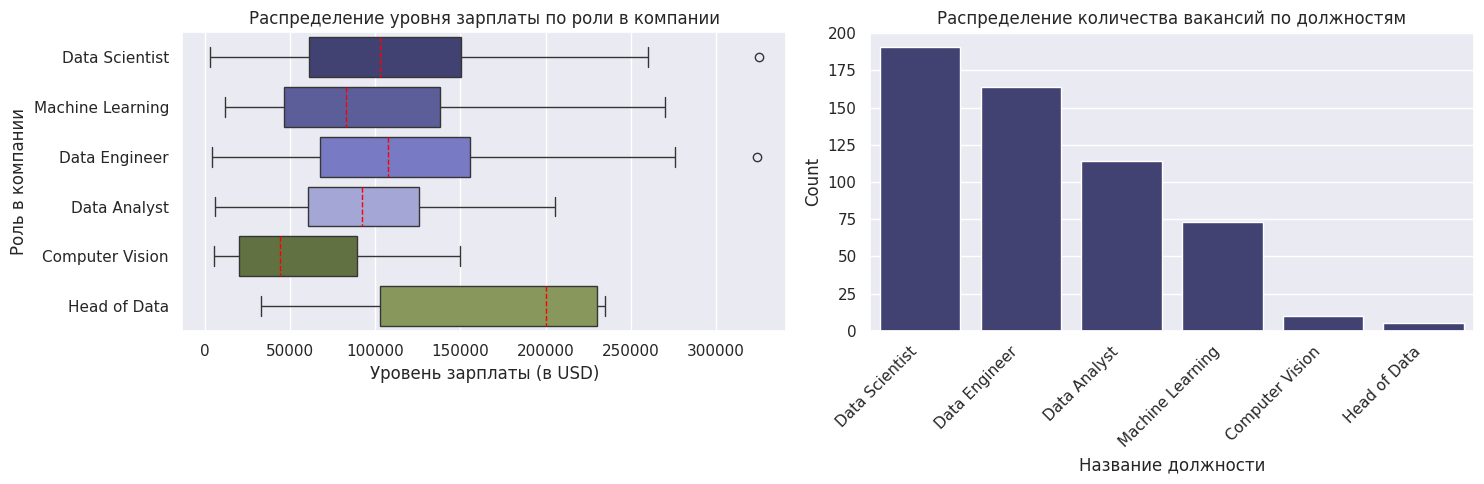

In [61]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Создаем boxplot, применяя разные цвета для каждого уровня опыта
axes[0] = sns.boxplot(
    data=cleaned,
    x='salary_in_usd',
    y='job_title',
    orient='h',
    medianprops={"color": "red", "linestyle": '--'},
    hue='job_title',
    ax=axes[0]
)

# Настраиваем подписи осей
axes[0].set(xlabel='Уровень зарплаты (в USD)', ylabel='Роль в компании')

# Установка заголовка графика
axes[0].set_title('Распределение уровня зарплаты по роли в компании')

# Считаем количество работ по каждому типу трудоустройства
df_job = cleaned['job_title'].value_counts().reset_index()

# Создаем barplot
axes[1] = sns.barplot(
    data=df_job,
    x='job_title',
    y='count'
)

# Настраиваем подписи осей
axes[1].set(xlabel='Название должности', ylabel='Count')

# Установка заголовка второго графика
axes[1].set_title('Распределение количества вакансий по должностям')

# Поворачиваем метки по оси X
axes[1].set_xticks(range(len(df_job['job_title'])))  # Устанавливаем позиции меток
axes[1].set_xticklabels(df_job['job_title'], rotation=45, ha='right')  # Устанавливаем метки с поворотом

# Отображаем график
plt.tight_layout()  # Чтобы избежать перекрытия меток и графиков
# Отображаем график
plt.show()

In [62]:
df_info = cleaned.groupby('job_title')['salary_in_usd'].describe().round()
print('Распределение уровня зарплаты по роли в компании')
df_info

Распределение уровня зарплаты по роли в компании


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Computer Vision,10.0,58767.0,50704.0,5409.0,20180.0,44304.0,89310.0,150000.0
Data Analyst,114.0,93048.0,45104.0,6072.0,60325.0,92000.0,125922.0,205300.0
Data Engineer,164.0,113617.0,60859.0,4000.0,67616.0,107400.0,155400.0,324000.0
Data Scientist,191.0,109535.0,61202.0,2859.0,61112.0,103000.0,150500.0,325000.0
Head of Data,5.0,160163.0,88780.0,32974.0,102839.0,200000.0,230000.0,235000.0
Machine Learning,73.0,101484.0,70096.0,12000.0,46597.0,82744.0,138000.0,270000.0


Среди сфер работы наиболее популярными в данных являются:
* Data Scientist
* Data Engineer
* Data Analyst
* Machine Learning

Уровень зарплаты среди Data Scientist и Data Engineer очень близки. Роли, требующие более высоких технических навыков и опыта, таких как **Data Engineer** и **Data Scientist**, показывают высокие уровни зарплат, что подчеркивает растущий спрос на специалистов в этой области.

**Head of Data** имеет самую высокую среднюю зарплату (160163 USD), хотя и имеет наименьшее количество вакансий (5). Это подчеркивает высокую ценность данной позиции для компании, а также то, что она является, как правило, более тяжелой из-за высокого уровня ответственности и лидерских навыков, необходимых для данной роли.

## Распределение зарплаты в разных сферах Data science по годам.

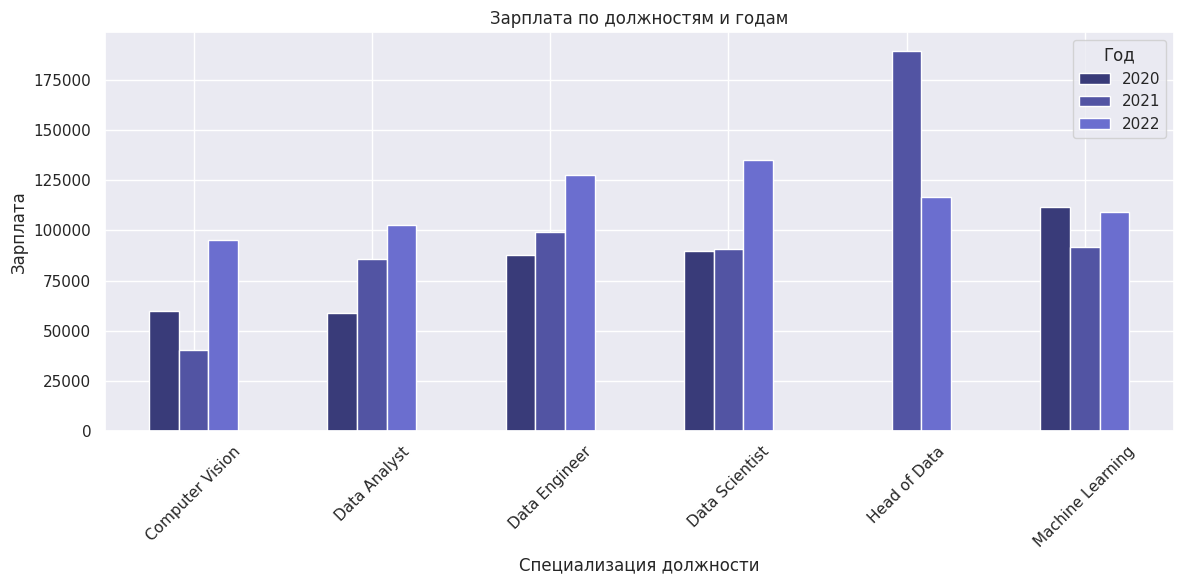

In [63]:
# Создаем сводную таблицу, в которой по индексам будут должности.
# В столбцах указан год работы, значением будет средняя зарплата
pivot = cleaned.pivot_table(
    index='job_title',
    columns='work_year',
    values='salary_in_usd',
    fill_value=0).round()

# Строим график
pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Зарплата по должностям и годам')
plt.xlabel('Специализация должности')
plt.ylabel('Зарплата')
plt.xticks(rotation=45)
plt.legend(title='Год')

plt.tight_layout()

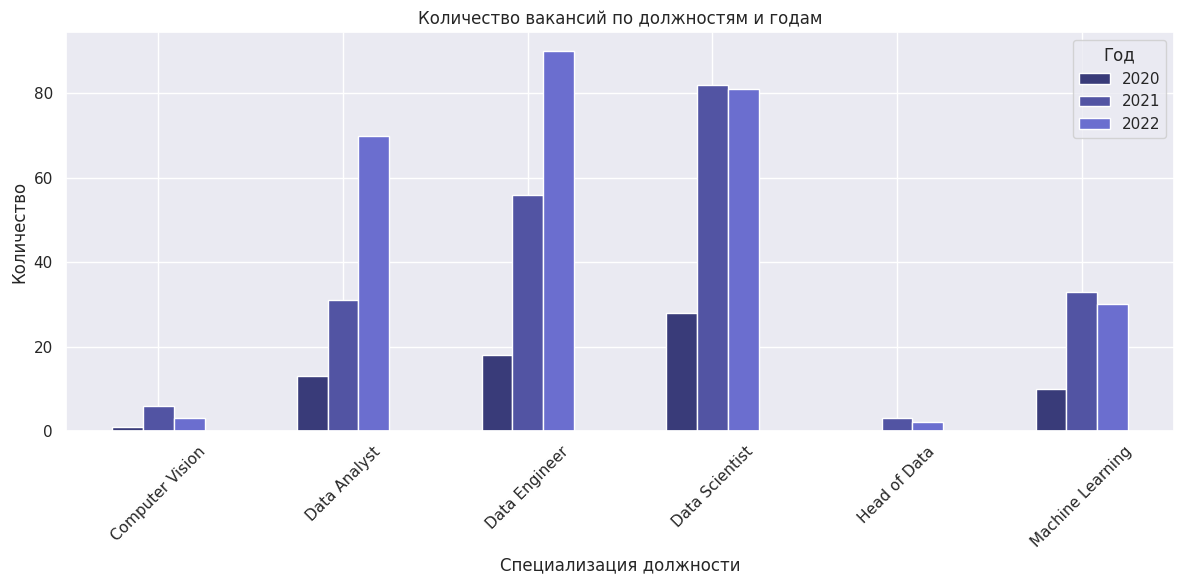

In [64]:
pivot_1 = cleaned.pivot_table(
    index='job_title',
    columns='work_year',
    values='salary_in_usd',
    fill_value=0,
    aggfunc='count').round()

# Строим график
pivot_1.plot(kind='bar', figsize=(12, 6))
plt.title('Количество вакансий по должностям и годам')
plt.xlabel('Специализация должности')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.legend(title='Год')

plt.tight_layout()

У **Data scientist**, **Data engineer** и **Data analyst** наблюдается рост уровня зарплат с каждым годом, а также увеличение количества предложений для этих направлений.
Наблюдался постоянный рост зарплаты у Data Engineer. У Data Scientist до 2022 года, повышение среднего уровня зарплаты было незначительным. В 2022 году произошло резкое повышение оплаты труда.
С каждым годом количество предложений на рынке труда для сферы Data Science растет. Как и растут требования к соикателям. Сейчас эта область стремительно развивается и поэтому требуются квалифицированные специалисты для которых соответственно требуется достойный уровень зарплаты.
К 2022 году уровни зарплат между специалистами Data scientist и Data Engineer практически выровнялись. А вот количество предложений для Data engineer резко увеличилось.

## Распредение зарплаты разных областей Data science в зависимости от местоположения компании.

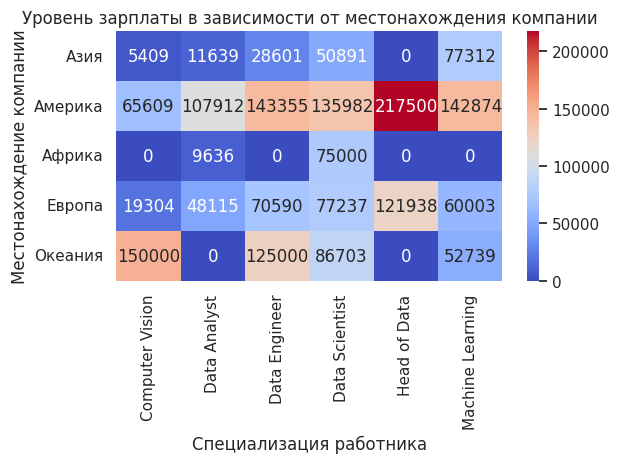

In [65]:
# Загружаем xml файл с соответсвием кода страны и ее названия
name_of_countries = pd.read_xml('https://www.artlebedev.ru/country-list/xml/')

# Создаем копию датафрейма
df_copy = cleaned.copy()

# Формируем новые столбцы с названием страны и ее местоположении  на русском языке
df_copy['country'] = df_copy['company_location'].apply(lambda x: name_of_countries[name_of_countries['alpha2'] == x]['name'].iloc[0])
df_copy['location'] = df_copy['company_location'].apply(lambda x: name_of_countries[name_of_countries['alpha2'] == x]['location'].iloc[0])
df_copy['salary_in_usd'] = df_copy['salary_in_usd']

# Создаем сводную таблицу с локациями, должностями и уровнем зарплат
pivot_2 = df_copy.pivot_table(
    index='location',
    columns='job_title',
    values='salary_in_usd',
    fill_value=0).round()

# Строим тепловую карту
sns.heatmap(pivot_2, cmap='coolwarm', annot=True, fmt='.0f')

# Установливаем заголовока графика и его осей
plt.title('Уровень зарплаты в зависимости от местонахождения компании')
plt.xlabel('Специализация работника')
plt.yticks(rotation=0)
plt.ylabel('Местонахождение компании')

plt.tight_layout()
# Отображаем график
plt.show()

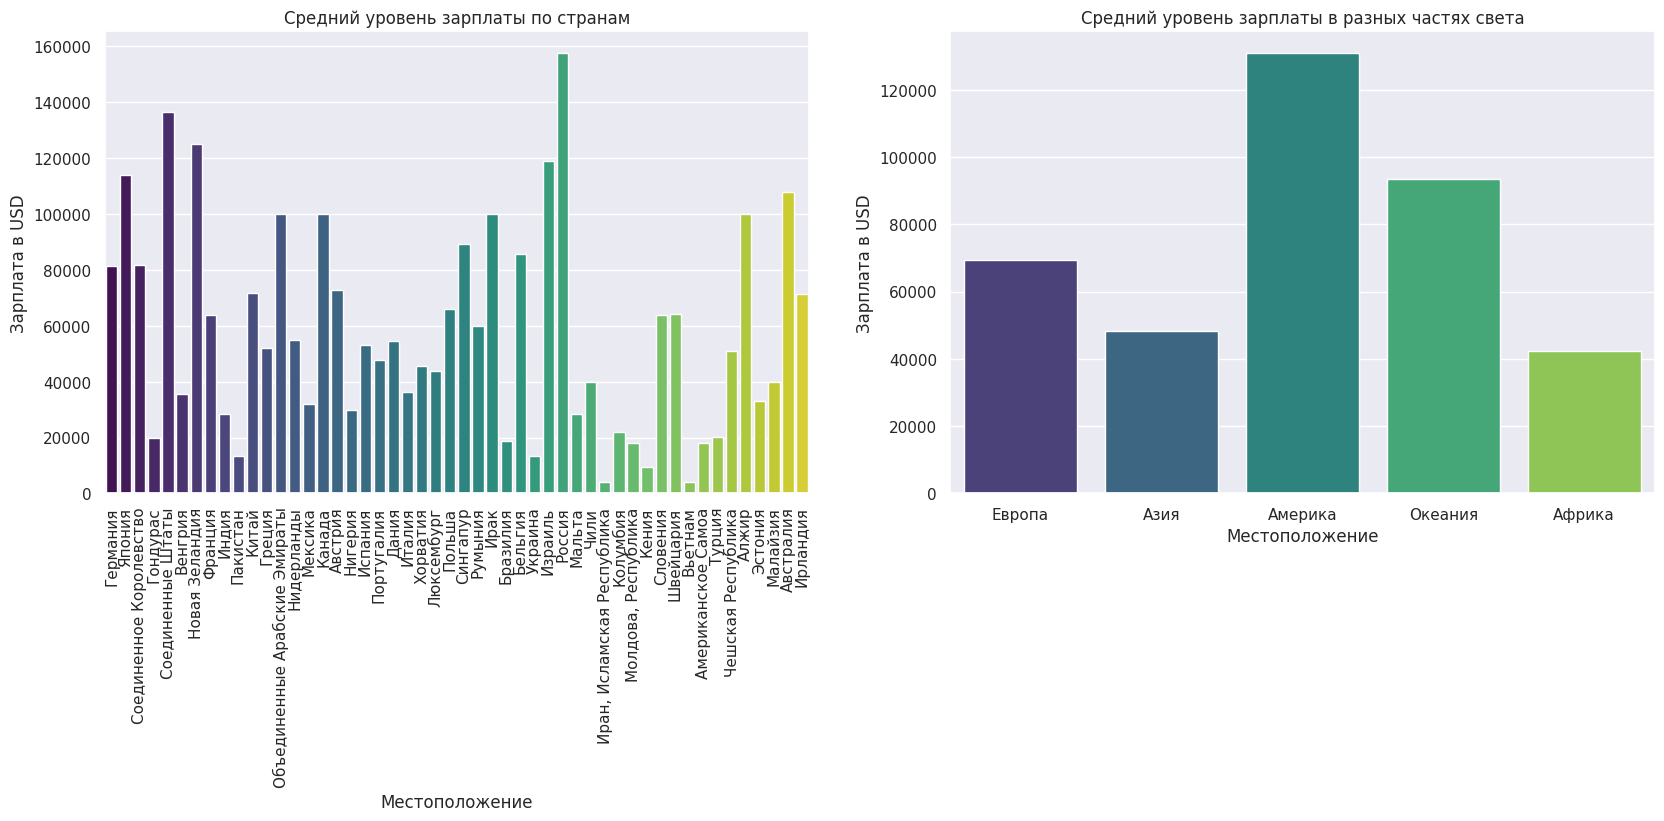

In [66]:
fig, axes = plt.subplots(1, 2,figsize=(20,6))

# Построение гистограммы
sns.barplot(data=df_copy, x='country', y='salary_in_usd', palette='viridis', ci=None, ax=axes[0])

# Настройка графика
axes[0].set_title('Средний уровень зарплаты по странам')
axes[0].set_xlabel('Местоположение')
axes[0].set_ylabel('Зарплата в USD')
axes[0].tick_params(axis='x', rotation=90)

# Построение гистограммы
sns.barplot(data=df_copy, x='location', y='salary_in_usd', palette='viridis', ci=None, ax=axes[1])

# Настройка графика
axes[1].set_title('Средний уровень зарплаты в разных частях света')
axes[1].set_xlabel('Местоположение')
axes[1].set_ylabel('Зарплата в USD')

# Показать график
plt.show()

Компании, находящиеся в Америке, предлагают самые высокие зарплаты на мировом рынке. Хотя в Европе в целом уровень зарплат ниже, Россия выделяется как лидер по среднему уровню доходов, опережая Соединенные Штаты.

Среди стран, демонстрирующих наивысший средний уровень заработной платы в области Data Science, можно выделить:
* Россия
* Соединенные Штаты
* Новая Зеландия
* Израиль
* Япония

В то же время Вьетнам, Иран, Украина и Пакистан являются государствами с самым низким уровнем зарплат.

Если рассмотреть уровень зарплат по различным сферам деятельности, становится очевидным, что вакансии в области Data Science распространены практически по всему миру. Однако в Африке в основном представлены роли Analyst и Scientist, при этом зафиксирована значительная разница в их заработках. Специалисты на позиции Scientist в Африке могут зарабатывать в 7-8 раз больше, чем аналитики.

В Соединенных Штатах специалисты по Data Science и Data Engineering пользуются высоким спросом, что подтверждается соответствующими высокими зарплатами. Это может быть следствием увеличения потребности в анализе данных и передовых аналитических технологиях в бизнесе.

В Европе и Америке зарплаты для Data Scientist и Data Engineer выделяются схожестью, с разницей всего 7-8 тысяч долларов США. Тем не менее, в разных регионах существуют значительные различия в предложениях работодателей: в Америке компании чаще готовы предлагать более высокую оплату для Data Engineer, в то время как в Европе Data Scientist получают более высокие зарплаты. Это может указывать на различия в рыночном спросе и предложении трудовых ресурсов в разных регионах.

В Азии уровень заработной платы по большинству специальностей остается довольно низким по сравнению с другими регионами, что может объясняться различиями в экономическом развитии, уровнем жизни и потребностью в трудовых специалистах.

Специалисты в области Data Science и Data Engineering также высоко ценятся в Америке, в то время как в Океании наблюдается спрос на специалистов в области Computer Vision, а в Соединенных Штатах — на Analyst и Machine Learning.

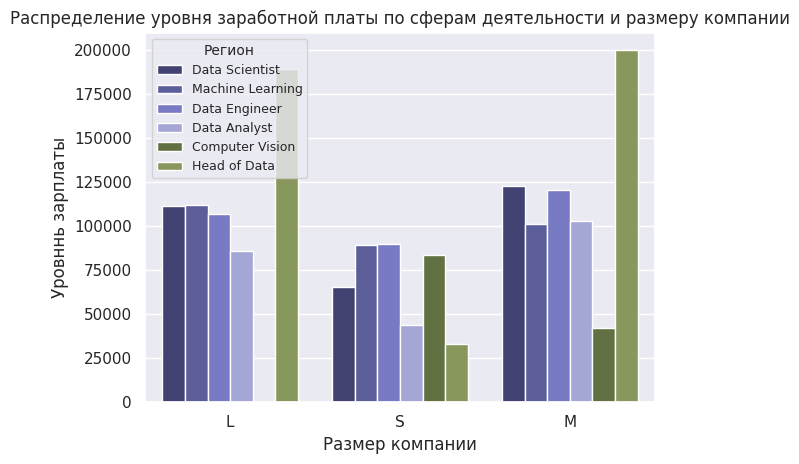

In [67]:
sns.barplot(
    data=df_copy,
    x="company_size",
    y="salary_in_usd",
    hue="job_title",
    ci=None
)

# Настройка подписей и осей
plt.title("Распределение уровня заработной платы по сферам деятельности и размеру компании")
plt.xlabel("Размер компании")
plt.ylabel("Уровннь зарплаты")
plt.legend(title='Регион', title_fontsize='10', fontsize='9', loc='upper left', frameon=True)

plt.tight_layout()

Если сравнимать небольшую и среднюю по размеру компанию, то уровень зарплат выше у более крупной компании. Но сравнивая среднюю и крупную компании, уровень зарплат наоборот выше у более мелкой компании.
это может быть обучловлено тем, что в маленьких клмпаниях не всегда тркбуются сотрудники в области data science. Чаще такие сотрудники требуются в более крупные компании. В крупной компании как правило есть целые отделы, в которых много сотрудников и каждый решает свою небольшую задачу. Что нельзп сказать про среднюю, там может быть 1-2 таких сотрудника, на плечи которых упадет обьем работы целого отдела. отсюда и получается,что оклал выше в средней по размеру компании, но и требований больш.
в крупных клмпания все сотрудники daya scirnce получают приблизительно одинаковую зарплату, ща исключением аналитиков. Аналитикам предлагают более низкий оклад. В целом вне зависимости от размера компании у data scientist  и data engineer примерно одинаковый уровень заработной платы, который значительно выше, чем у аналитиеов

### Итоговые выводы по исследованию уровня заработной платы в области Data Science и Data Engineering

1. **Потребность в специалистах**: В последние годы наблюдается высокий спрос на специалистов в области Data Science и Data Engineering, особенно в Америке, где компании активно ищут профессионалов для анализа данных и разработки машинного обучения. В Океании спрос сосредоточен на специалистах в области Computer Vision.

2. **Размер компании и уровень зарплат**: Исследование показало, что между заработной платой в малых, средних и крупных компаниях существуют определенные закономерности. В крупных компаниях уровень зарплаты для специалистов обычно одинаков, за исключением аналитиков, которые получают меньшие оклады. Напротив, в средних по размеру компаниях зарплаты могут быть выше, так как на 1-2 сотрудника могут возлагаться обязанности целого отдела.

3. **Разница в зарплатах среди ролей**: Уровень заработной платы для Data Scientist и Data Engineer по большей части схож и значительно превышает зарплаты аналитиков. Это указывает на высокую ценность и потребность в технических навыках в этих ролях.

4. **Региональные различия**: Разные регионы демонстрируют значительные различия в зарплатах.

### Влияющие факторы на уровень заработной платы

На уровень заработной платы в области Data Science и Data Engineer могут влиять следующие факторы:
- **Опыт работы**: Уровень зарплат возрастает с увеличением опыта. Это касается как junior, middle, так и senior и director специалистов.
- **Тип занятости**: Полная занятость может коррелировать с более высокими зарплатами.
- **Область деятельности**: Разные сферы (например, Data Scientist, Data Engineer, Analyst) имеют свои уровни заработной платы в зависимости от спроса и предложений на рынке труда.
- **Размер компании**: Размер организации также оказывает влияние. Размер компании – малые, средние или крупные – влияет на распределение обязанностей и тем самым на уровень зарплаты.
- **Географические различия**: В разных странах и регионах уровень заработной платы варьируется, что может быть связано с экономическими условиями и уровнем жизни.



## Статистический анализ

In [68]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
      print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
      print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
  print('p-value = {:.3f}'.format(p))
  if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
  else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

Чтобы ответить на этот вопрос проведем 2 теста:
* Сначала установим увеличилась ли зарплата в 2021 году по сравнению с 2020.
* Потом сравним измения с 2021 ао 2022.
Если в ходе каждого теста будет установлено, что был зафиксиром статистически значимый рост, тогда можно будет сделать вывод о том, что у специалистов в области Data Scientist дейсвительно с каждым годом увеличиваются зарплаты.

1. Увеличилась ли зарплата в 2021 году по сравнению с 2020 годом у Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата за 2021 год ($μ_1$) статистически меньше либо равна размеру заработной плате за 2020 год ($μ_2$)

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата за 2021 год ($μ_1$) статистически больше, чем размер средней арплаты за 2020 год ($μ_2$).
$$ H_1 : μ_1 > μ_2$$




In [69]:
# значения зарплаты
salary_2020 = cleaned.loc[(cleaned['work_year']==2020) & (cleaned['job_title']=='Data Scientist'), 'salary_in_usd']
salary_2021 = cleaned.loc[(cleaned['work_year']==2021) & (cleaned['job_title']=='Data Scientist'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

2020:
p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Размер заработной платы»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [73]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2021, salary_2020, alternative='greater')
decision_hypothesis(p)

p-value = 0.338
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


2. Увеличилась ли зарплата в 2022 году по сравнению с 2021 годом у Data Scientist?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата за 2022 год ($μ_1$) статистически меньше либо равна размеру заработной плате за 2021 год ($μ_2$)

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата за 2022 год ($μ_1$) статистически больше, чем размер средней арплаты за 2021 год ($μ_2$).
$$ H_1 : μ_1 > μ_2$$


In [71]:
# значения зарплат зв 2021, 2022 г.
salary_2021 = cleaned.loc[(cleaned['work_year']==2021) & (cleaned['job_title']=='Data Scientist'), 'salary_in_usd']
salary_2022 = cleaned.loc[(cleaned['work_year']==2022) & (cleaned['job_title']=='Data Scientist'), 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(salary_2022)
decision_normality(result[1])

2021:
p-value = 0.005
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2022:
p-value = 0.657
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


In [74]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2022, salary_2021, alternative='greater')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Нельзя говорить о том, что зарплата Data Scientist увеличивается с каждым годом. Но можно с уверенностью сказать, что за 2022 год установили статистически значимый рост заработной платы.

## Есть ли рост заработной платы с каждым годом в целом для области Data Science?

Для этого проведем исследование в 2 этапа:
1. Установим есть ли статистически значимый рост заработной платы в 2021 году.
2. Установим есть ли сттистически значимый рост заработной платы в 2022 году.


1. Увеличилась ли зарплата в 2021 году по сравнению с 2020 годом?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Средняя зарплата за 2021 год ($μ_1$) статистически меньше либо равна размеру заработной плате за 2020 год ($μ_2$)

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Средняя зарплата за 2021 год ($μ_1$) статистически больше, чем размер средней арплаты за 2020 год ($μ_2$).
$$ H_1 : μ_1 > μ_2$$

In [78]:
# значения заработной платы
salary_in_2020 = cleaned[cleaned['work_year']==2020]['salary_in_usd']
salary_in_2021 = cleaned[cleaned['work_year']==2021]['salary_in_usd']
salary_in_2022 = cleaned[cleaned['work_year']==2022]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_in_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_in_2021)
decision_normality(result[1])

print('2022:')
result = stats.shapiro(salary_in_2021)
decision_normality(result[1])


2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2022:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [80]:
# проводим первый тест
_, p = stats.mannwhitneyu(salary_in_2021, salary_in_2020, alternative='greater')
decision_hypothesis(p)
# проводим второй тест
_, p = stats.mannwhitneyu(salary_in_2022, salary_in_2021, alternative='greater')
decision_hypothesis(p)

p-value = 0.206
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Пока нет оснований гворить о том, что есть рост заработной платы с каждым годом в целом по области Data Science.

## Зарплата Data Scientist больше чем у Data Engineer в 2022 году?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплата за 2022 год Data Scientist ($μ_1$) статистически меньше либо равна размеру заработной плате за 2022 год Data Engineer ($μ_2$)

$$ H_0 : μ_1 <= μ_2$$

*Альтернативная гипотеза* ($H_1$): Зарплата за 2022 год Data Scientist ($μ_1$) cтатистически больше, чем размер заработной платы за 2022 год Data Engineer ($μ_2$)

$$ H_1 : μ_1 > μ_2$$


In [82]:
# значения заработной платы
salary_2022_DS = cleaned[(cleaned['work_year']==2022) & (cleaned['job_title'] == 'Data Scientist')]['salary_in_usd']
salary_2022_EN = cleaned[(cleaned['work_year']==2022) & (cleaned['job_title'] == 'Data Engineer')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Data Scientist:')
result = stats.shapiro(salary_2022_DS)
decision_normality(result[1])

print('Data Engineer:')
result = stats.shapiro(salary_2022_EN)
decision_normality(result[1])


Data Scientist:
p-value = 0.657
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Data Engineer:
p-value = 0.020
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [85]:
# проводим тест
_, p = stats.mannwhitneyu(salary_2022_DS, salary_2022_EN, alternative='greater')
decision_hypothesis(p)

p-value = 0.121
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


У нас нет оснований говорить о том, что в 2022 году у Data Scientist зарплата больше, чем у Data Engineer.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?


**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием вакансий (Data Science, Data Engineer) и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием вакансий (Data Science, Data Engineer) и размером компании есть взаимосвязь (признаки зависимы).

In [93]:
# устанавливаем значение 1 если вакансия Data scientist или Data Engineer
yes_or_no_DS_EN = cleaned['job_title'].apply(lambda x: 1 if x == 'Data Scientist' or x == 'Data Engineer' else 0).reset_index()

# составляем таблицу сопряжённости
cross_table = pd.crosstab(cleaned['company_size'], yes_or_no_DS_EN['job_title'])
cross_table

job_title,0,1
company_size,,
L,72,114
M,89,164
S,27,54


In [94]:
# проводим тест
_, p, _, _ = stats.chi2_contingency(cross_table)
decision_hypothesis(p)

p-value = 0.634
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Наличие вакансий data scientist и data engineer не связана с размером компании.

### Оценим различие в зарплатах Data Scientist в крмпаниях различного размера (маленькие, средние, крупные) для того, чтобы понять есть ли статистически значимые различия в оплате труда в разны компаниях.

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплата Data Scientist в маленькой компании($μ_1$) статистически равна размеру заработной плате в средней компании ($μ_2$) и статистически равна размеру зараотной платы в большой компанни ($μ_3$)

$$ H_0 : μ_1 = μ_2 = μ_3$$

*Альтернативная гипотеза* ($H_1$):  Зарплата Data Scientist в маленькой компании($μ_1$) статистически не равна размеру заработной плате в средней компании ($μ_2$) и статистически не равна размеру зараотной платы в большой компанни ($μ_3$)

$$ H_1 : μ_1 \neq μ_2 \neq μ_3$$


In [100]:
# значения заработной платы в компаниях разного размера
salary_s = cleaned[(cleaned['company_size']=='S') & (cleaned['job_title'] == 'Data Scientist')]['salary_in_usd']
salary_m = cleaned[(cleaned['company_size']=='M') & (cleaned['job_title'] == 'Data Scientist')]['salary_in_usd']
salary_l = cleaned[(cleaned['company_size']=='L') & (cleaned['job_title'] == 'Data Scientist')]['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Company S:')
result = stats.shapiro(salary_s)
decision_normality(result[1])

print('Company M:')
result = stats.shapiro(salary_m)
decision_normality(result[1])

print('Company L:')
result = stats.shapiro(salary_l)
decision_normality(result[1])

Company S:
p-value = 0.046
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Company M:
p-value = 0.776
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Company L:
p-value = 0.003
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Три.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [101]:
# проводим тест
_, p = stats.kruskal(salary_s, salary_m, salary_l)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Заработная плата в компаниях разного размера различается.

###  Существуют ли значительные различия в уровне заработной платы между различными регионами?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплата  в Америке ($μ_1$) статистически равна размеру заработной платы в Европе ($μ_2$), статистически равна размеру заработной платы в Азии ($μ_3$), статистически равна размеру заработной платы в Африке ($μ_4$) и равна размеру заработной платы в Океании ($μ_5$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4 = μ_5$$

*Альтернативная гипотеза* ($H_1$):  Зарплата  в Америке ($μ_1$) статистически не равна размеру заработной платы в Европе ($μ_2$), статистически не равна размеру заработной платы в Азии ($μ_3$), статистически не равна размеру заработной платы в Африке ($μ_4$) и не равна размеру заработной платы в Океании ($μ_5$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4 \neq μ_5$$


In [104]:
salary_usa = df_copy[df_copy['location'] == 'Америка']['salary_in_usd']
salary_eur = df_copy[df_copy['location'] == 'Европа']['salary_in_usd']
salary_as = df_copy[df_copy['location'] == 'Азия']['salary_in_usd']
salary_afr = df_copy[df_copy['location'] == 'Африка']['salary_in_usd']
salary_oc = df_copy[df_copy['location'] == 'Океания']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Америка:')
result = stats.shapiro(salary_usa)
decision_normality(result[1])

print('Европа:')
result = stats.shapiro(salary_eur)
decision_normality(result[1])

print('Азия:')
result = stats.shapiro(salary_as)
decision_normality(result[1])

print('Африка:')
result = stats.shapiro(salary_afr)
decision_normality(result[1])

print('Океания:')
result = stats.shapiro(salary_oc)
decision_normality(result[1])

Америка:
p-value = 0.029
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Европа:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Азия:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Африка:
p-value = 0.268
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Океания:
p-value = 0.691
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Пять.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [105]:
# проводим тест
_, p = stats.kruskal(salary_usa, salary_eur, salary_as, salary_afr, salary_oc)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Зарпата в разных регионах различается.

###  Существуют ли значительные различия в уровне заработной платы в зависимости от опыта работы?
**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплата junior ($μ_1$) статистически равна размеру заработной платы midlle ($μ_2$), статистически равна размеру заработной платы senior ($μ_3$), статистически равна размеру заработной платы director ($μ_4$).

$$ H_0 : μ_1 = μ_2 = μ_3 = μ_4$$

*Альтернативная гипотеза* ($H_1$):  Зарплата junior ($μ_1$) статистически не равна размеру заработной платы midlle ($μ_2$), статистически не равна размеру заработной платы senior ($μ_3$), статистически не равна размеру заработной платы director ($μ_4$).

$$ H_1 : μ_1 \neq μ_2 \neq μ_3 \neq μ_4$$


In [106]:
# заработная плата для каждого опыта работы
salary_jun = df_copy[df_copy['experience_level'] == 'EN']['salary_in_usd']
salary_mid = df_copy[df_copy['experience_level'] == 'MI']['salary_in_usd']
salary_sen = df_copy[df_copy['experience_level'] == 'SE']['salary_in_usd']
salary_dir = df_copy[df_copy['experience_level'] == 'EX']['salary_in_usd']


# проводим тест Шапиро-Уилка
print('Junior:')
result = stats.shapiro(salary_jun)
decision_normality(result[1])

print('Midle:')
result = stats.shapiro(salary_mid)
decision_normality(result[1])

print('Senior:')
result = stats.shapiro(salary_sen)
decision_normality(result[1])

print('Director:')
result = stats.shapiro(salary_dir)
decision_normality(result[1])

Junior:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Midle:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Senior:
p-value = 0.352
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным
Director:
p-value = 0.260
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Четыре.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Для проверки нашей гипотезы можно использовать критерий Краскела — Уоллиса.

**Проведём тест**

In [107]:
# проводим тест
_, p = stats.kruskal(salary_jun, salary_mid, salary_sen, salary_dir)
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Уровень заработной платы отличается в зависимости от опыта работы соискателя.

### Уровень заработной платы выше в средних по размеру компаниях по сравнению с крупными и малыми.

Сформулируем нулевую и альтернативные гипотезы

Нулевая гипотеза ( H0 ): Зарплата в средних компаниях (μ1) не выше, чем в крупных (μ2) и малышах (μ3)
$$H0:\mu_1 \leq \mu_2 \quad \text{и} \quad \mu_1 \leq \mu_3$$

Альтернативная гипотеза ( H1 ): Зарплата в средних компаниях (μ1) выше, чем в крупных (μ2) и малышах (μ3)d
$$H1:\mu_1 > \mu_2 \quad \text{и} \quad \mu_1 > \mu_3$$


In [119]:
df_size = cleaned[cleaned['job_title'].isin(['Data Scientist', 'Data Engineer', 'Data Analyst'])]
# значения заработной платы в компаниях разного размера
sal_s = df_size[df_size['company_size']=='S']['salary_in_usd']
sal_m = df_size[df_size['company_size']=='M']['salary_in_usd']
sal_l = df_size[df_size['company_size']=='L']['salary_in_usd']

# проводим тест Шапиро-Уилка
print('Company S:')
result = stats.shapiro(sal_s)
decision_normality(result[1])

print('Company M:')
result = stats.shapiro(sal_m)
decision_normality(result[1])

print('Company L:')
result = stats.shapiro(sal_l)
decision_normality(result[1])

Company S:
p-value = 0.026
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Company M:
p-value = 0.017
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
Company L:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест в 2 этапа**
1. Сравним среднюю компанию с крупной
2. Сравним среднюю с малой


In [120]:
# проводим первый тест
_, p = stats.mannwhitneyu(sal_m, sal_l, alternative='greater')
decision_hypothesis(p)
# проводим второй тест
_, p = stats.mannwhitneyu(sal_m, sal_s, alternative='greater')
decision_hypothesis(p)

p-value = 0.016
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


Заработная плата Data Scientist, Data Engineer, Data Analyst выше всего в средних по размеру компаниях.

### В Соединенных Штатах специалисты получают зароботную плату больше 135000 USD

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): Зарплата в России ($μ_1$) статистически меньше или равна 135000

$$ H_0 : μ_1 <= 135000$$

*Альтернативная гипотеза* ($H_1$): Зарплата в России ($μ_1$) статистически больше 135000

$$ H_1 : μ_1 > 135000$$


In [134]:
df_us = df_copy[(df_copy['job_title'].isin(['Data Scientist', 'Data Engineer'])) & (df_copy['country'] == 'Соединенные Штаты')]['salary_in_usd']
# значения заработной платы в компаниях разного размера

# проводим тест Шапиро-Уилка
print('Cоединенные Штаты:')
result = stats.shapiro(df_us)
decision_normality(result[1])


Cоединенные Штаты:
p-value = 0.230
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Заработная плата»? — Количественный.
* Сколько сравниваемых групп? — Одна.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

Чтобы проверить нашу гипотезу, можно использовать одновыборочный t-критерий.


In [141]:
# проводим тест
_, p = stats.ttest_1samp(df_us, 135000, alternative='greater')
decision_hypothesis(p)

p-value = 0.007
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


В Соединенных Штатах для Data Scientist, Engineer и Analyst зарплаты выше 135000 USD.

## Итоговые выводы

1. Заработная плата зависит:
   * Опыта работы
   * Региона компании
   * Размера компании
2. Пока не наблюдается стабильного ежегодного роста зароботной платы для специалистов Data Scientist и Data Engineer. Но в 2022 году было статистически значимое увеличение зарплаты.
3. По последним данным нет статистически значимых различий в зарплате Data Scientist и Data Engineer.
4. Самые высокие оклады в Соединенных Штатах. Там зарплаты выше 135000 USD.
5. Заработная плата Data Scientist, Data Engineer, Data Analyst выше всего в средних по размеру компаниях.
6. Размер компании не зависит от наличия в ней специалистов Data Scientist и Data Engineer.
